In [40]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import pytz
import re
from astropy.table import Table
import matplotlib.pyplot as plt
from scipy import stats

In [41]:
extended_exposure_table = Table.read('extended_exposure_data.ecsv').to_pandas()
wind_table = Table.read('wind_data.ecsv').to_pandas()
shake_table = Table.read('wind_shake.ecsv').to_pandas()
exposure_table = Table.read('exposure_data.ecsv').to_pandas()

In [42]:
extended_exposure_table

,EXPID,MJD,TIMESTAMP,EXPTIME,SURVEY,PROGRAM,MOUNT_EL,MOUNT_AZ,WIND_GUST_SUM,WIND_SHAKE_SUM,WIND_SPEED_AVG,WIND_SPEED_STD,WIND_DIRECTION_AVG,WIND_DIRECTION_STD,GUST_AVG,GUST_STD,WIND_OPENING_ANGLE
0,90224,59364.148239,2021-05-30 03:33:27.850,348.878632,sv3,BACKUP,81.250550,143.299106,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,90225,59364.154715,2021-05-30 03:42:47.376,1054.206299,sv3,BRIGHT,56.109587,201.243202,22.0,18.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,90226,59364.168720,2021-05-30 04:02:57.408,764.646790,sv3,BRIGHT,55.605450,203.827782,5.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,90227,59364.180144,2021-05-30 04:19:24.442,387.648407,sv3,BRIGHT,81.073074,216.819257,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,90239,59364.276238,2021-05-30 06:37:46.963,145.539062,sv3,BACKUP,78.369745,3.222720,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20479,260588,60615.483601,2024-11-01 11:36:23.126,1212.025391,main,DARK,60.429956,53.165474,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
20480,260589,60615.498972,2024-11-01 11:58:31.181,592.853638,main,DARK,64.034535,50.657696,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
20481,260590,60615.507241,2024-11-01 12:10:25.622,848.233887,main,DARK,60.190277,47.773534,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
20482,260591,60615.518416,2024-11-01 12:26:31.142,718.755310,main,DARK,65.895887,53.515450,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


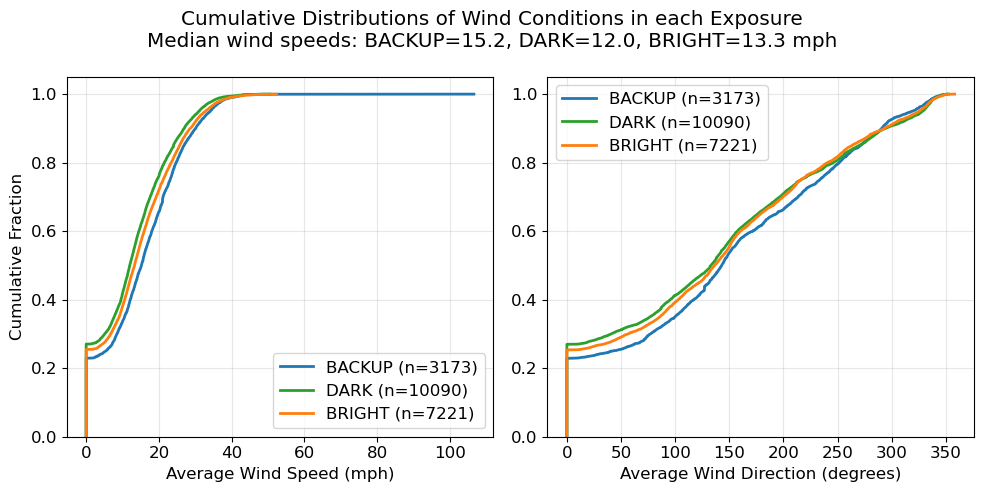

In [43]:
def plot_wind_distributions(df):
    """
    Create two-panel plot showing cumulative distributions of wind speed
    and wind direction, colored by program type.
    
    Parameters:
    -----------
    df : pandas.DataFrame
        DataFrame containing columns: 
        PROGRAM, WIND_SPEED_AVG, WIND_DIRECTION_AVG
    """
    # Set up the figure and subplots
    fig, axes = plt.subplots(1, 2, figsize=(10, 5))
    
    # Calculate median wind speeds for each program
    medians = {program: df[df['PROGRAM'] == program]['WIND_SPEED_AVG'].median() 
              for program in ['BACKUP', 'DARK', 'BRIGHT']}
    
    # Create caption with median values
    median_text = f"Median wind speeds: BACKUP={medians['BACKUP']:.1f}, DARK={medians['DARK']:.1f}, BRIGHT={medians['BRIGHT']:.1f} mph"
    fig.suptitle(f'Cumulative Distributions of Wind Conditions in each Exposure\n{median_text}')
    
    # Define colors and programs
    programs = ['BACKUP', 'DARK', 'BRIGHT']
    colors = ['#1f77b4', '#2ca02c', '#ff7f0e']  # blue, green, orange
    
    # Plot wind speed distributions
    for program, color in zip(programs, colors):
        # Get data for this program
        mask = df['PROGRAM'] == program
        data = df[mask]['WIND_SPEED_AVG'].dropna()
        
        # Sort data and calculate cumulative distribution
        sorted_data = np.sort(data)
        cumulative = np.arange(1, len(sorted_data) + 1) / len(sorted_data)
        
        # Plot
        axes[0].plot(sorted_data, cumulative, 
                    label=f'{program} (n={len(data)})',
                    color=color, linewidth=2)
    
    # Customize wind speed subplot
    axes[0].grid(True, alpha=0.3)
    axes[0].set_xlabel('Average Wind Speed (mph)')
    axes[0].set_ylabel('Cumulative Fraction')
    axes[0].legend()
    axes[0].set_ylim(0, 1.05)
    
    # Plot wind direction distributions
    for program, color in zip(programs, colors):
        # Get data for this program
        mask = df['PROGRAM'] == program
        data = df[mask]['WIND_DIRECTION_AVG'].dropna()
        
        # Sort data and calculate cumulative distribution
        sorted_data = np.sort(data)
        cumulative = np.arange(1, len(sorted_data) + 1) / len(sorted_data)
        
        # Plot
        axes[1].plot(sorted_data, cumulative, 
                    label=f'{program} (n={len(data)})',
                    color=color, linewidth=2)
    
    # Customize wind direction subplot
    axes[1].grid(True, alpha=0.3)
    axes[1].set_xlabel('Average Wind Direction (degrees)')
    axes[1].set_ylabel('')  # Remove y-label on right plot
    axes[1].legend()
    axes[1].set_ylim(0, 1.05)
    
    # Adjust layout
    plt.tight_layout()
    plt.savefig('wind_cumulative_distributions.jpg')
    
# Create the plot
_ = plot_wind_distributions(extended_exposure_table)

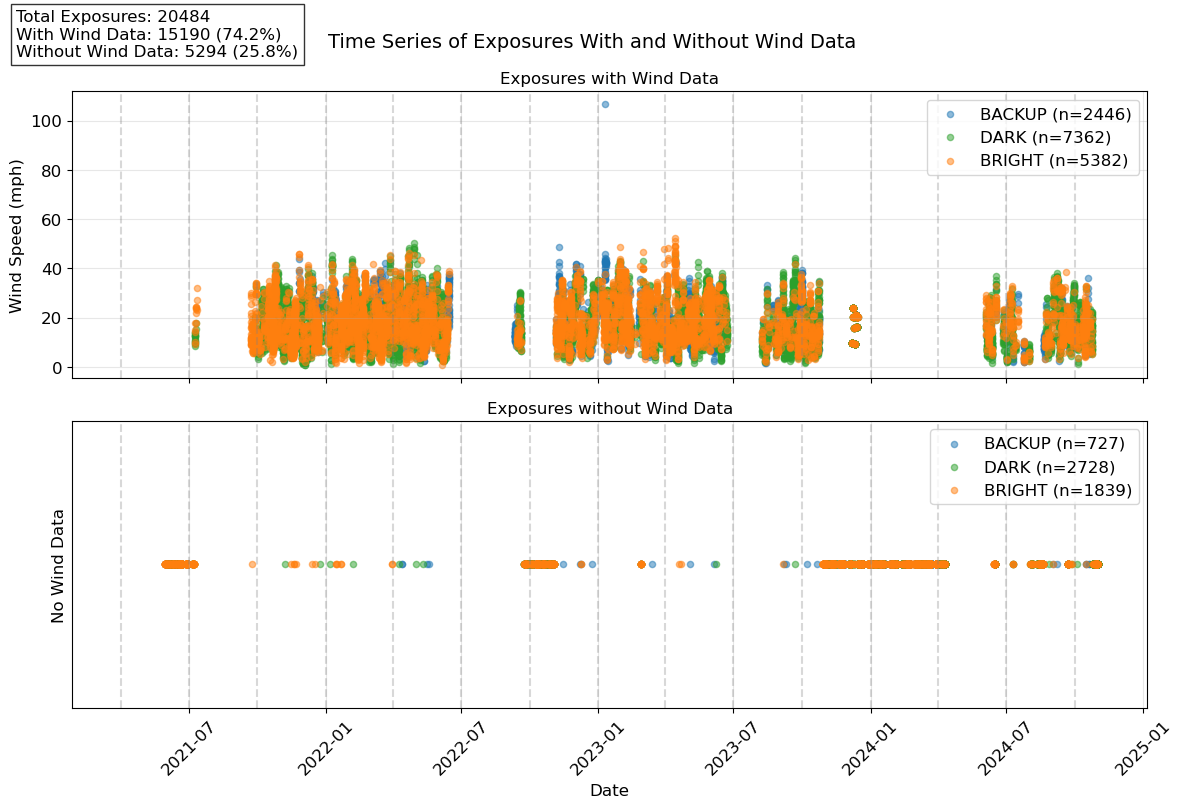

In [27]:
def plot_exposure_time_series(df):
    """
    Create time series plot showing exposures with and without wind data.
    
    Parameters:
    -----------
    df : pandas.DataFrame
        DataFrame containing columns: 
        TIMESTAMP, WIND_SPEED_AVG, PROGRAM
    """
    plt.rcParams.update({'font.size': 12})  # Increase base font size
    
    # Convert timestamp to datetime if needed
    df['TIMESTAMP'] = pd.to_datetime(df['TIMESTAMP'])
    
    # Filter data to start from April 2021
    start_date = pd.Timestamp('2021-04-01')
    df = df[df['TIMESTAMP'] >= start_date]
    
    # Create masks for exposures with and without wind data
    has_wind = df['WIND_SPEED_AVG'] > 1E-5
    no_wind = df['WIND_SPEED_AVG'] <= 1E-5
    
    # Set up the figure
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8), sharex=True)
    fig.suptitle('Time Series of Exposures With and Without Wind Data', fontsize=14)
    
    # Create quarterly dates for vertical lines
    end_year = df['TIMESTAMP'].max().year
    quarter_months = [1, 4, 7, 10]  # January, April, July, October
    quarterly_dates = []
    
    for year in range(2021, end_year + 1):
        for month in quarter_months:
            # Skip dates before April 2021
            if year == 2021 and month < 4:
                continue
            quarterly_dates.append(pd.Timestamp(year=year, month=month, day=1))
    
    # Plot exposures by program
    programs = ['BACKUP', 'DARK', 'BRIGHT']
    colors = ['#1f77b4', '#2ca02c', '#ff7f0e']  # blue, green, orange
    
    # First subplot: Exposures with wind data
    for program, color in zip(programs, colors):
        mask = (df['PROGRAM'] == program) & has_wind
        data = df[mask]
        ax1.scatter(data['TIMESTAMP'], data['WIND_SPEED_AVG'], 
                   c=color, label=f'{program} (n={len(data)})', 
                   alpha=0.5, s=20)
    
    # Add quarterly lines to first subplot
    for date in quarterly_dates:
        ax1.axvline(date, color='gray', linestyle='--', alpha=0.3)
    
    ax1.set_ylabel('Wind Speed (mph)', fontsize=12)
    ax1.grid(True, alpha=0.3)
    ax1.legend(fontsize=12)
    ax1.set_title('Exposures with Wind Data', fontsize=12)
    ax1.tick_params(labelsize=12)
    
    # Second subplot: Exposures without wind data
    for program, color in zip(programs, colors):
        mask = (df['PROGRAM'] == program) & no_wind
        data = df[mask]
        dates = data['TIMESTAMP']
        # Just plot markers at y=1 for exposures without wind data
        ax2.scatter(dates, np.ones_like(dates), 
                   c=color, label=f'{program} (n={len(data)})', 
                   alpha=0.5, s=20)
    
    # Add quarterly lines to second subplot
    for date in quarterly_dates:
        ax2.axvline(date, color='gray', linestyle='--', alpha=0.3)
    
    ax2.set_ylabel('No Wind Data', fontsize=12)
    ax2.set_yticks([])  # Remove y-axis ticks
    ax2.grid(True, alpha=0.3)
    ax2.legend(fontsize=12)
    ax2.set_title('Exposures without Wind Data', fontsize=12)
    ax2.tick_params(labelsize=12)
    
    # Format x-axis
    plt.xticks(rotation=45)
    ax2.set_xlabel('Date', fontsize=12)
    
    # Calculate percentages
    total = len(df)
    with_wind = has_wind.sum()
    without_wind = no_wind.sum()
    percent_with = (with_wind / total) * 100
    percent_without = (without_wind / total) * 100
    
    # Add text box with statistics
    stats_text = (f'Total Exposures: {total}\n'
                 f'With Wind Data: {with_wind} ({percent_with:.1f}%)\n'
                 f'Without Wind Data: {without_wind} ({percent_without:.1f}%)')
    
    fig.text(0.02, 0.95, stats_text, fontsize=12, 
             bbox=dict(facecolor='white', alpha=0.8))
    
    # Adjust layout
    plt.tight_layout()
    plt.savefig('exposure_time_series.jpg')
    
# Create the plot
_ = plot_exposure_time_series(extended_exposure_table)

In [30]:
def calculate_angle_difference(angle1, angle2):
    """
    Calculate the absolute angular difference between two angles in degrees,
    considering the circular nature of angles (0-360 degrees).
    
    Parameters:
    -----------
    angle1, angle2 : float
        Angles in degrees
        
    Returns:
    --------
    float
        Absolute angular difference in degrees (0-180)
    """
    diff = abs(angle1 - angle2) % 360
    return min(diff, 360 - diff)

In [50]:

def get_exposure_timeseries(exposure_id, exposure_table, shake_table, wind_table):
    """
    Get exposure data and corresponding shake and wind data that fall within 
    the time window of a specific exposure. Also calculates the opening angle
    between wind direction and telescope azimuth and creates a time series plot.
    
    Parameters:
    exposure_id (int): ID of the exposure to analyze
    exposure_table (pandas.DataFrame): DataFrame containing exposure data with columns:
        - EXPID: exposure identifier
        - TIMESTAMP: start timestamp of exposure
        - EXPTIME: exposure duration in seconds
        - MOUNT_AZ: telescope azimuth angle
        - TILEID: tile identifier
    shake_table (pandas.DataFrame): DataFrame containing shake data with timestamp column
    wind_table (pandas.DataFrame): DataFrame containing wind data with:
        - TIMESTAMP: timestamp column
        - WIND_DIRECTION: wind direction in degrees
        - WIND_SPEED: wind speed
    
    Returns:
    tuple: (exposure_data, shake_data, wind_data) where:
           - exposure_data is a DataFrame containing the single exposure row with added opening_angle
           - shake_data and wind_data are DataFrames containing only the rows that fall
             within the exposure time window
    """
    # Get the specific exposure's row
    exposure_data = exposure_table[exposure_table['EXPID'] == exposure_id].copy()
    exposure = exposure_data.iloc[0]
    
    # Calculate the time window
    start_time = pd.to_datetime(exposure['TIMESTAMP'])
    window_length = exposure['EXPTIME']
    end_time = start_time + pd.Timedelta(seconds=window_length)
    
    # Filter shake data for the exposure time window
    shake_data = shake_table[
        (shake_table['TIMESTAMP'] >= start_time) &
        (shake_table['TIMESTAMP'] <= end_time)
    ].copy()
    
    # Filter wind data for the exposure time window
    wind_data = wind_table[
        (wind_table['TIMESTAMP'] >= start_time) &
        (wind_table['TIMESTAMP'] <= end_time)
    ].copy()
    
    # Add exposure_id to both DataFrames for reference
    shake_data['EXPID'] = exposure_id
    wind_data['EXPID'] = exposure_id
    
    # Sort both DataFrames by timestamp for consistency
    shake_data = shake_data.sort_values('TIMESTAMP')
    wind_data = wind_data.sort_values('TIMESTAMP')
    
    # Calculate average wind direction for the exposure period
    wind_direction_avg = wind_data['WIND_DIRECTION'].mean()
    
    # Calculate opening angle
    opening_angle = calculate_angle_difference(wind_direction_avg, exposure['MOUNT_AZ'])
    
    # Add opening angle to exposure data
    exposure_data['OPENING_ANGLE'] = opening_angle
    
    # Calculate opening angle time series
    wind_data['OPENING_ANGLE'] = wind_data['WIND_DIRECTION'].apply(
        lambda x: calculate_angle_difference(x, exposure['MOUNT_AZ'])
    )
    
    # Convert timestamps to seconds since exposure start
    wind_data['seconds'] = (wind_data['TIMESTAMP'] - start_time).dt.total_seconds()
    
    # Create the time series plot with horizontal layout
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12, 5), sharey=False)
    
    # Plot wind speed
    ax1.plot(wind_data['seconds'], wind_data['WIND_SPEED'], 'b-', label='Wind Speed')
    ax1.scatter(wind_data['seconds'], wind_data['WIND_SPEED'], color='blue', alpha=0.5, s=20)
    ax1.set_ylabel('Wind Speed (mph)')
    ax1.set_xlabel('Time (seconds since exposure start)')
    ax1.grid(True)
    ax1.legend()
    
    # Plot wind direction
    ax2.plot(wind_data['seconds'], wind_data['WIND_DIRECTION'], 'g-', label='Wind Direction')
    ax2.scatter(wind_data['seconds'], wind_data['WIND_DIRECTION'], color='green', alpha=0.5, s=20)
    ax2.set_ylabel('Wind Direction (degrees)')
    ax2.set_xlabel('Time (seconds since exposure start)')
    ax2.grid(True)
    ax2.legend()
    
    # Plot opening angle
    ax3.plot(wind_data['seconds'], wind_data['OPENING_ANGLE'], 'r-', label='Opening Angle')
    ax3.scatter(wind_data['seconds'], wind_data['OPENING_ANGLE'], color='red', alpha=0.5, s=20)
    ax3.set_ylabel('Opening Angle (degrees)')
    ax3.set_xlabel('Time (seconds since exposure start)')
    ax3.grid(True)
    ax3.legend()
    
    # Set title for the entire figure
    start_str = start_time.strftime('%Y-%m-%d %H:%M:%S')
    fig.suptitle(f'Wind and Opening Angle Time Series\n'
                f'EXPID: {exposure_id}, Program: {exposure["PROGRAM"]}\n'
                f'TELESCOPE_AZ: {exposure["MOUNT_AZ"]:.1f}°, Exposure Time: {exposure["EXPTIME"]:.1f}s\n'
                f'Start Time: {start_str}')
    
    # Adjust layout to prevent overlap
    plt.tight_layout()
    
    # Save the figure
    plt.savefig(f'expid_{exposure_id}_timeseries.jpg')
    plt.close()
    
    return exposure_data, shake_data, wind_data

In [51]:
has_wind_event = (extended_exposure_table['WIND_GUST_SUM']+extended_exposure_table['WIND_SHAKE_SUM'])>0
large_angle = abs(extended_exposure_table['WIND_OPENING_ANGLE']-140)<5.0
high_speed = abs(extended_exposure_table['WIND_SPEED_AVG']-10.0)<5.0
special_exposures = extended_exposure_table[has_wind_event & large_angle & high_speed]
print(len(special_exposures))
print(len(extended_exposure_table))
for i in range(len(special_exposures)):
    _ = get_exposure_timeseries(special_exposures.iloc[i]['EXPID'], exposure_table, shake_table, wind_table)

12
20484


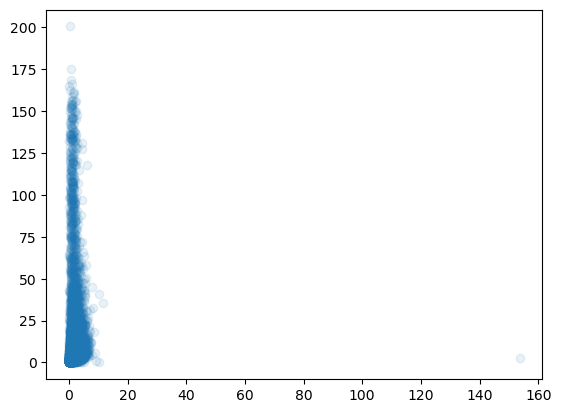

In [5]:
plt.scatter(exposure_table['WIND_SPEED_STD'], exposure_table['WIND_DIRECTION_STD'], alpha=0.1)

In [6]:
no_gust = exposure_table['WIND_GUST_SUM']==0
no_shake = exposure_table['WIND_SHAKE_SUM']==0
no_wind_speed = exposure_table['WIND_SPEED_AVG']<1E-5
print(np.count_nonzero(no_gust))
print(np.count_nonzero(no_shake))
print(np.count_nonzero(no_wind_speed))
print(len(exposure_table))

15256
16489
5294
20484


In [7]:
ii = ~(no_wind_speed)
print(np.count_nonzero(ii))
new_exposure_table = exposure_table[ii]

15190


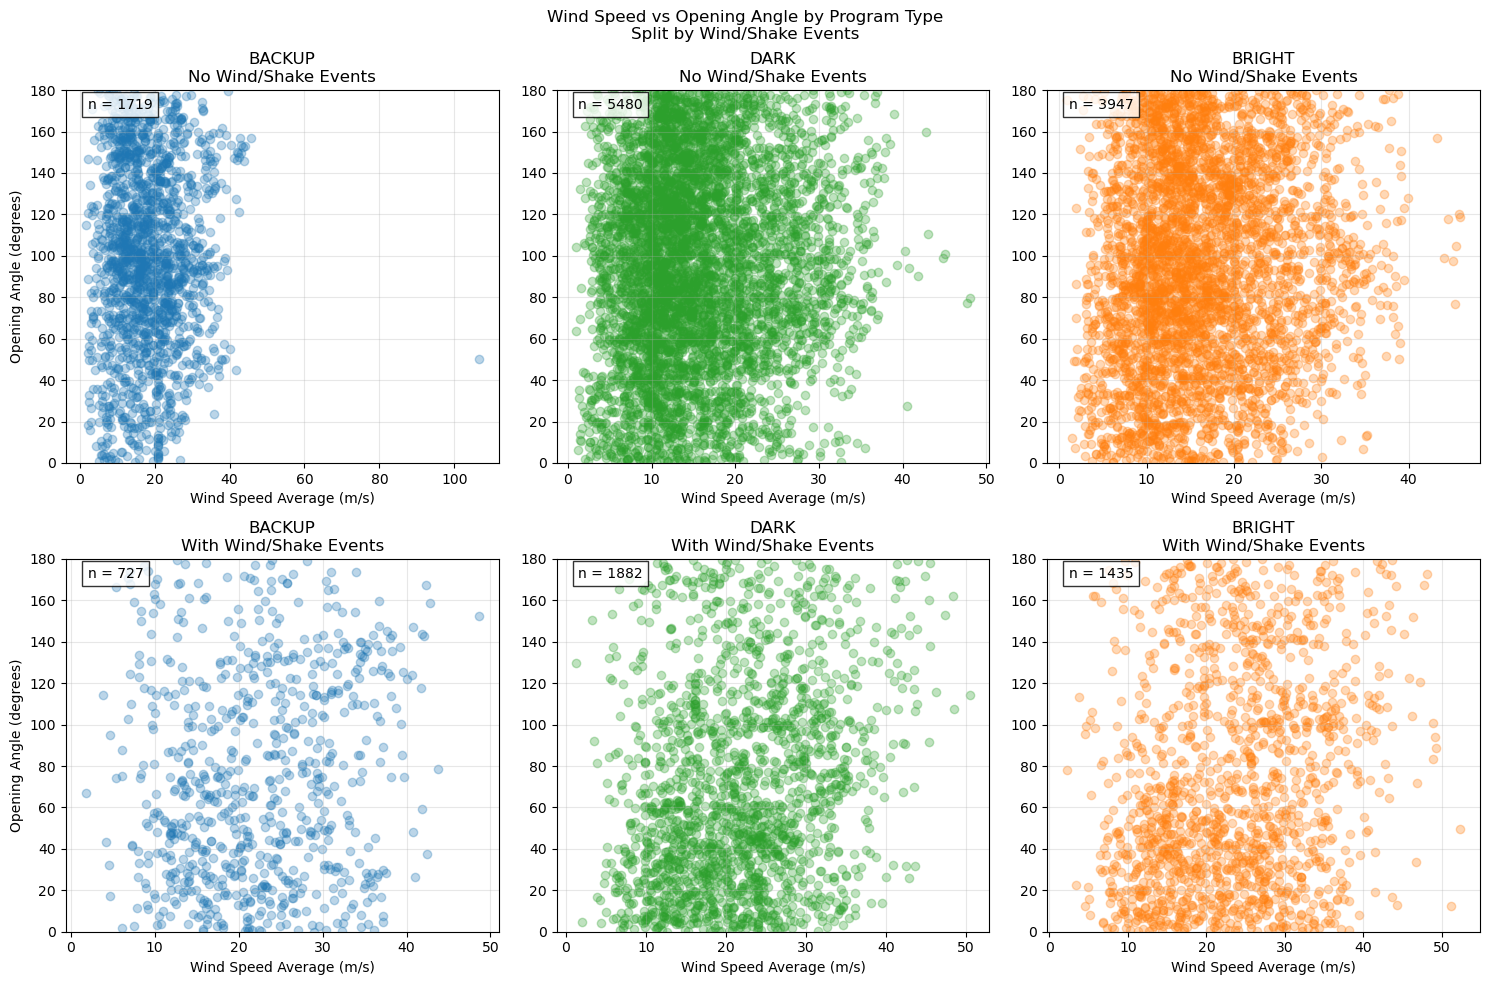

In [8]:
def plot_wind_speed_vs_angle_split(df):
    """
    Create a six-panel scatter plot of wind speed vs opening angle,
    separated by program type and presence/absence of wind/shake events.
    
    Parameters:
    -----------
    df : pandas.DataFrame
        DataFrame containing columns: 
        PROGRAM, WIND_SPEED_AVG, WIND_OPENING_ANGLE, WIND_GUST_SUM, WIND_SHAKE_SUM
    """
    # Set up the figure and subplots
    fig, axes = plt.subplots(2, 3, figsize=(15, 10))
    fig.suptitle('Wind Speed vs Opening Angle by Program Type\nSplit by Wind/Shake Events')
    
    # Define colors and programs
    programs = ['BACKUP', 'DARK', 'BRIGHT']
    colors = ['#1f77b4', '#2ca02c', '#ff7f0e']  # blue, green, orange
    
    # Create scatter plot for each program and condition
    for col, (program, color) in enumerate(zip(programs, colors)):
        for row, has_events in enumerate([False, True]):
            ax = axes[row, col]
            
            # Create mask for program and wind/shake condition
            program_mask = df['PROGRAM'] == program
            if has_events:
                event_mask = (df['WIND_GUST_SUM'] + df['WIND_SHAKE_SUM']) > 0
                title_prefix = 'With'
            else:
                event_mask = (df['WIND_GUST_SUM'] + df['WIND_SHAKE_SUM']) == 0
                title_prefix = 'No'
            
            combined_mask = program_mask & event_mask
            program_data = df[combined_mask]
            
            # Create scatter plot
            ax.scatter(program_data['WIND_SPEED_AVG'], 
                      program_data['WIND_OPENING_ANGLE'],
                      alpha=0.3, c=color, label=program)
            
            # Add labels
            ax.set_xlabel('Wind Speed Average (m/s)')
            if col == 0:
                ax.set_ylabel('Opening Angle (degrees)')
            ax.set_title(f'{program}\n{title_prefix} Wind/Shake Events')
            
            # Set y-axis limits
            ax.set_ylim(0, 180)
            
            # Add grid
            ax.grid(True, alpha=0.3)
            
            # Add count of points
            count = len(program_data)
            ax.text(0.05, 0.95, f'n = {count}', 
                    transform=ax.transAxes,
                    bbox=dict(facecolor='white', alpha=0.8))
    
    # Adjust layout to prevent overlap
    plt.tight_layout()
    plt.savefig('summary.jpg')
    return fig, axes

# Create the plot
fig, axes = plot_wind_speed_vs_angle_split(new_exposure_table)

# Display the plot
#plt.show()

In [9]:
def plot_cumulative_distributions(df):
    """
    Create three-panel plot showing cumulative distributions of wind speed,
    opening angle, and wind gust sum for each program type.
    
    Parameters:
    -----------
    df : pandas.DataFrame
        DataFrame containing columns: 
        PROGRAM, WIND_SPEED_AVG, WIND_OPENING_ANGLE, WIND_GUST_SUM
    """
    # Set up the figure and subplots
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    fig.suptitle('Cumulative Distributions by Program Type')
    
    # Define colors and programs
    programs = ['BACKUP', 'DARK', 'BRIGHT']
    colors = ['#1f77b4', '#2ca02c', '#ff7f0e']  # blue, green, orange
    
    # Variables to plot with their labels
    variables = ['WIND_SPEED_AVG', 'WIND_OPENING_ANGLE', 'WIND_SHAKE_SUM']
    xlabels = ['Wind Speed (mph)', 'Opening Angle (degrees)', 'Wind Shake Sum']
    
    # Create plots for each variable
    for ax, var, xlabel in zip(axes, variables, xlabels):
        for program, color in zip(programs, colors):
            # Get data for this program
            mask = df['PROGRAM'] == program
            data = df[mask][var].dropna()
            
            # Sort data and calculate cumulative distribution
            sorted_data = np.sort(data)
            cumulative = np.arange(1, len(sorted_data) + 1) / len(sorted_data)
            
            # Plot
            ax.plot(sorted_data, cumulative, 
                   label=f'{program} (n={len(data)})',
                   color=color, linewidth=2)
        
        # Customize each subplot
        ax.grid(True, alpha=0.3)
        ax.set_xlabel(xlabel)
        ax.set_ylabel('Cumulative Fraction' if ax == axes[0] else '')
        ax.legend()
        
        # Set y-axis limits
        ax.set_ylim(0, 1.05)
        
    # Adjust layout
    plt.tight_layout()
    
    return fig, axes

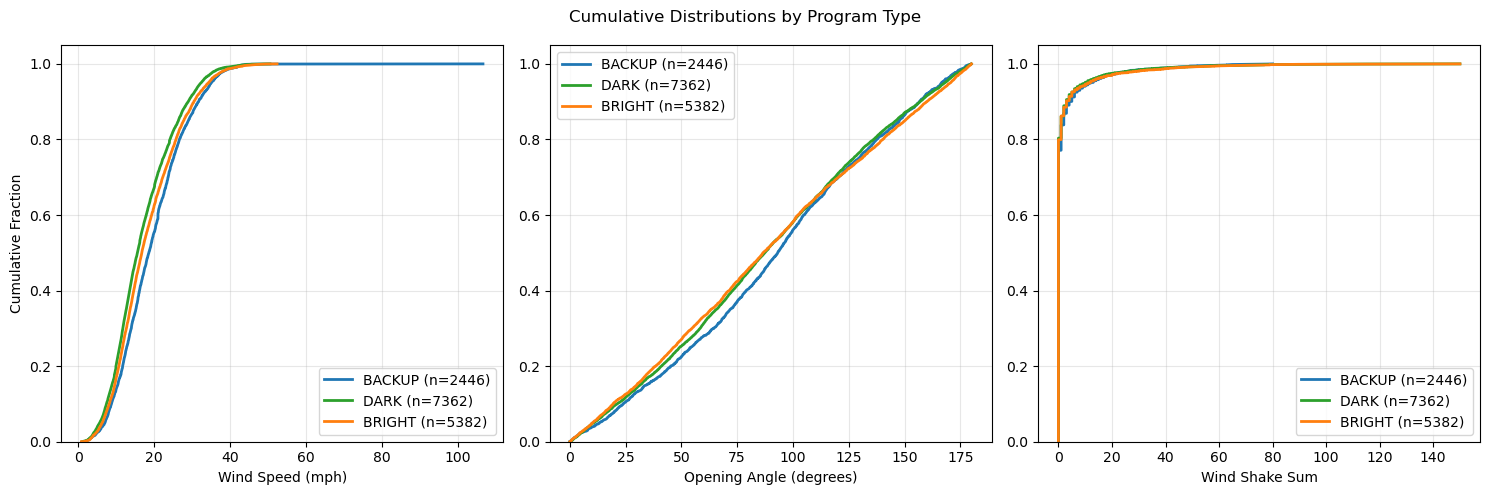

In [10]:
# Create the plot
fig, axes = plot_cumulative_distributions(new_exposure_table)

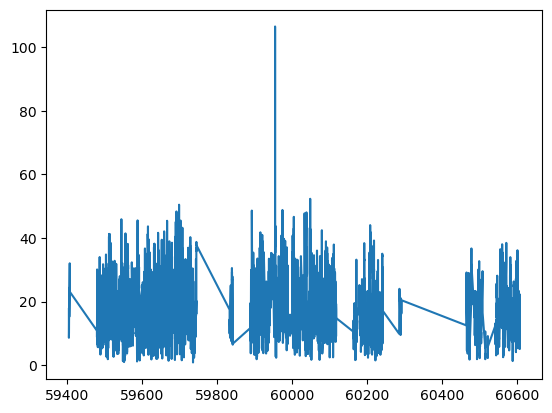

In [11]:
plt.plot(new_exposure_table['MJD'], new_exposure_table['WIND_SPEED_AVG'])

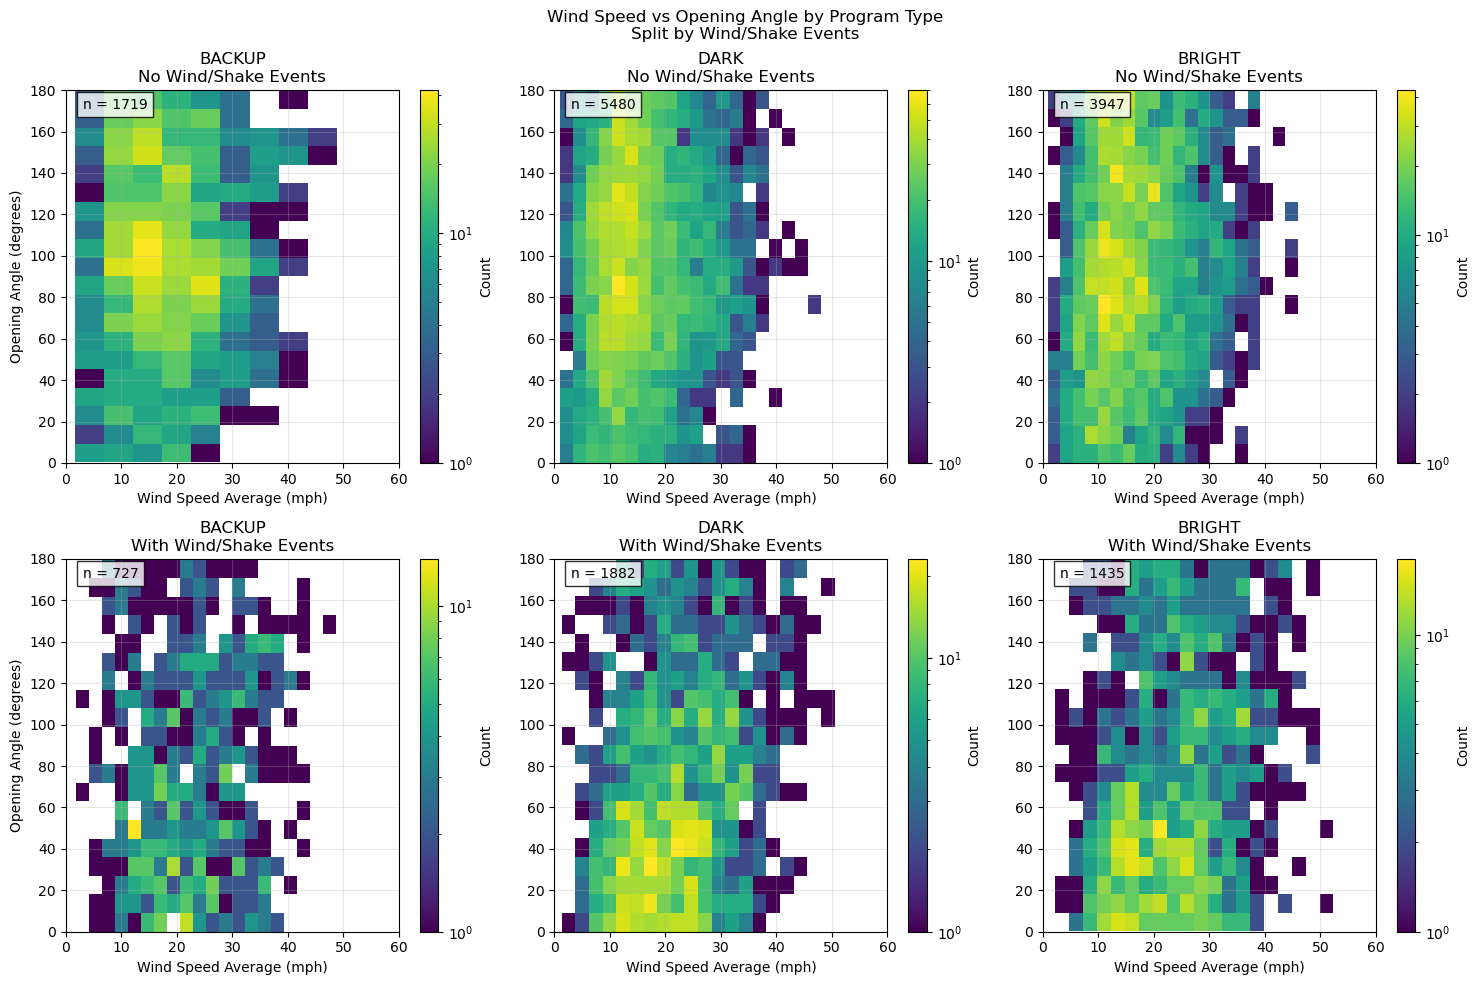

In [12]:
def plot_wind_speed_vs_angle_2dhist(df):
    """
    Create a six-panel 2D histogram of wind speed vs opening angle,
    separated by program type and presence/absence of wind/shake events.
    
    Parameters:
    -----------
    df : pandas.DataFrame
        DataFrame containing columns: 
        PROGRAM, WIND_SPEED_AVG, WIND_OPENING_ANGLE, WIND_GUST_SUM, WIND_SHAKE_SUM
    """
    # Set up the figure and subplots
    fig, axes = plt.subplots(2, 3, figsize=(15, 10))
    fig.suptitle('Wind Speed vs Opening Angle by Program Type\nSplit by Wind/Shake Events')
    
    # Define colors and programs
    programs = ['BACKUP', 'DARK', 'BRIGHT']
    
    # Create histogram for each program and condition
    for col, program in enumerate(programs):
        for row, has_events in enumerate([False, True]):
            ax = axes[row, col]
            
            # Create mask for program and wind/shake condition
            program_mask = df['PROGRAM'] == program
            if has_events:
                event_mask = (df['WIND_GUST_SUM'] + df['WIND_SHAKE_SUM']) > 0
                title_prefix = 'With'
            else:
                event_mask = (df['WIND_GUST_SUM'] + df['WIND_SHAKE_SUM']) == 0
                title_prefix = 'No'
            
            combined_mask = program_mask & event_mask
            program_data = df[combined_mask]
            
            # Create 2D histogram
            hist = ax.hist2d(program_data['WIND_SPEED_AVG'], 
                           program_data['WIND_OPENING_ANGLE'],
                           bins=(20, 20),  # You can adjust the number of bins
                           cmap='viridis',
                           norm=plt.matplotlib.colors.LogNorm())  # Use log scale for better visualization
            
            # Add colorbar
            plt.colorbar(hist[3], ax=ax, label='Count')
            
            # Add labels
            ax.set_xlabel('Wind Speed Average (mph)')
            if col == 0:
                ax.set_ylabel('Opening Angle (degrees)')
            ax.set_title(f'{program}\n{title_prefix} Wind/Shake Events')
            
            # Set y-axis limits
            ax.set_ylim(0, 180)
            ax.set_xlim(0,60)
            
            # Add grid
            ax.grid(True, alpha=0.3)
            
            # Add count of points
            count = len(program_data)
            ax.text(0.05, 0.95, f'n = {count}', 
                    transform=ax.transAxes,
                    bbox=dict(facecolor='white', alpha=0.8))
    
    # Adjust layout to prevent overlap
    plt.tight_layout()
    
    return fig, axes

# Create the plot
fig, axes = plot_wind_speed_vs_angle_2dhist(new_exposure_table)
plt.savefig('summary_2d.jpg')


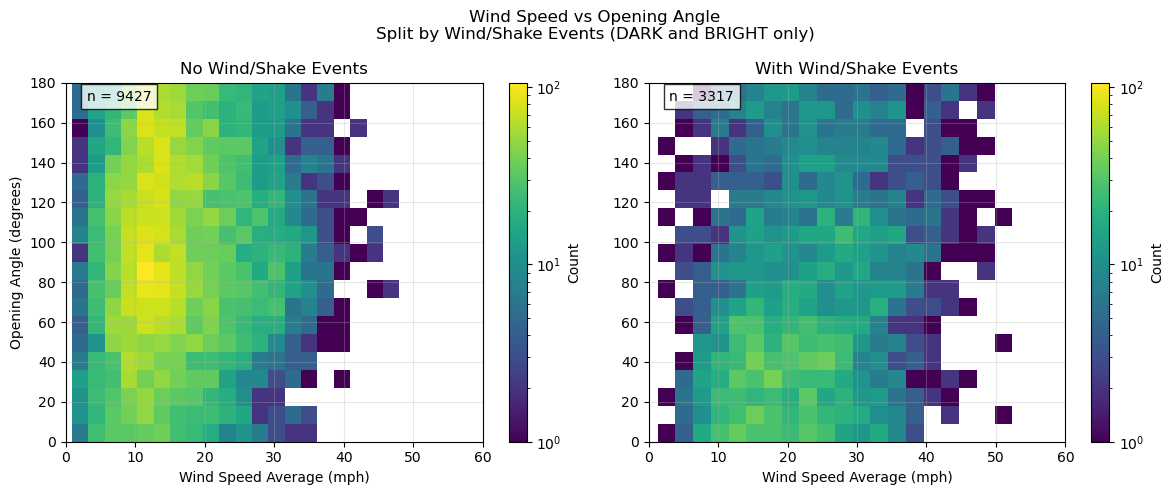

In [28]:
def plot_wind_speed_vs_angle_2dhist_no_backup(df):
    """
    Create a two-panel 2D histogram of wind speed vs opening angle,
    separated by presence/absence of wind/shake events,
    including only BRIGHT and DARK programs.
    
    Parameters:
    -----------
    df : pandas.DataFrame
        DataFrame containing columns: 
        PROGRAM, WIND_SPEED_AVG, WIND_OPENING_ANGLE, WIND_GUST_SUM, WIND_SHAKE_SUM
    """
    # Set up the figure and subplots
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))
    fig.suptitle('Wind Speed vs Opening Angle\nSplit by Wind/Shake Events (DARK and BRIGHT only)')
    
    # Create mask for DARK and BRIGHT programs
    program_mask = df['PROGRAM'].isin(['DARK', 'BRIGHT'])
    
    # Calculate the overall min and max counts for consistent colorbar
    all_counts = []
    bins = (20, 20)
    
    for has_events in [False, True]:
        if has_events:
            event_mask = (df['WIND_GUST_SUM'] + df['WIND_SHAKE_SUM']) > 0
        else:
            event_mask = (df['WIND_GUST_SUM'] + df['WIND_SHAKE_SUM']) == 0
            
        combined_mask = program_mask & event_mask
        filtered_data = df[combined_mask]
        
        counts, _, _ = np.histogram2d(filtered_data['WIND_SPEED_AVG'],
                                    filtered_data['WIND_OPENING_ANGLE'],
                                    bins=bins)
        all_counts.append(counts)
    
    # Find global min and max for colorbar (excluding zero counts)
    vmin = min(np.min(counts[counts > 0]) for counts in all_counts)
    vmax = max(np.max(counts) for counts in all_counts)
    
    # Create norm with consistent range
    norm = plt.matplotlib.colors.LogNorm(vmin=vmin, vmax=vmax)
    
    # Create histogram for each condition
    for i, has_events in enumerate([False, True]):
        ax = axes[i]
        
        # Create mask for wind/shake condition
        if has_events:
            event_mask = (df['WIND_GUST_SUM'] + df['WIND_SHAKE_SUM']) > 0
            title_prefix = 'With'
        else:
            event_mask = (df['WIND_GUST_SUM'] + df['WIND_SHAKE_SUM']) == 0
            title_prefix = 'No'
        
        # Combine masks
        combined_mask = program_mask & event_mask
        filtered_data = df[combined_mask]
        
        # Create 2D histogram with shared norm
        hist = ax.hist2d(filtered_data['WIND_SPEED_AVG'], 
                        filtered_data['WIND_OPENING_ANGLE'],
                        bins=bins,
                        cmap='viridis',
                        norm=norm)
        
        # Add colorbar
        plt.colorbar(hist[3], ax=ax, label='Count')
        
        # Add labels
        ax.set_xlabel('Wind Speed Average (mph)')
        if i == 0:
            ax.set_ylabel('Opening Angle (degrees)')
        ax.set_title(f'{title_prefix} Wind/Shake Events')
        
        # Set axis limits
        ax.set_ylim(0, 180)
        ax.set_xlim(0, 60)
        
        # Add grid
        ax.grid(True, alpha=0.3)
        
        # Add count of points
        count = len(filtered_data)
        ax.text(0.05, 0.95, f'n = {count}', 
                transform=ax.transAxes,
                bbox=dict(facecolor='white', alpha=0.8))
    
    # Adjust layout to prevent overlap
    plt.tight_layout()
    
    return fig, axes

fig, axes = plot_wind_speed_vs_angle_2dhist_no_backup(new_exposure_table)
plt.savefig('summary_2d_no_backup.jpg')

In [14]:
dark_high_speed = (new_exposure_table['WIND_SPEED_AVG']>30.0) & (new_exposure_table['PROGRAM']=='DARK')
high_speed = (new_exposure_table['WIND_SPEED_AVG']>30.0) 
with_shake = (new_exposure_table['WIND_SHAKE_SUM']+new_exposure_table['WIND_GUST_SUM'])>0
high_variance = (new_exposure_table['WIND_SPEED_STD']>4.0) 

print(np.count_nonzero(high_speed & with_shake))
print(np.count_nonzero(high_speed & ~with_shake))
print(np.count_nonzero(high_variance))


835
674
461


In [15]:
print(new_exposure_table[high_speed & with_shake][['EXPID', 'TIMESTAMP']])

        EXPID               TIMESTAMP
620     98271 2021-07-11 10:15:02.736
710    102085 2021-09-29 04:02:27.773
713    102088 2021-09-29 04:37:26.342
714    102089 2021-09-29 05:00:38.333
715    102090 2021-09-29 05:17:43.814
...       ...                     ...
19708  255597 2024-09-29 04:32:08.304
19709  255598 2024-09-29 04:54:34.243
20124  258489 2024-10-18 05:33:29.203
20125  258490 2024-10-18 05:45:53.712
20126  258503 2024-10-18 06:24:03.658

[835 rows x 2 columns]


In [16]:

def get_nightlog_path(timestamp):
    """
    Convert UTC timestamp to the corresponding local nightlog path.
    The night is defined as starting at 5pm Tucson time.
    """
    if isinstance(timestamp, str):
        timestamp = pd.to_datetime(timestamp)
    
    utc_tz = pytz.UTC
    if timestamp.tz is None:
        timestamp = timestamp.tz_localize(utc_tz)
    
    tucson_tz = pytz.timezone('America/Phoenix')
    tucson_time = timestamp.astimezone(tucson_tz)
    
    if tucson_time.hour < 17:
        tucson_time = tucson_time - timedelta(days=1)
    
    date_str = tucson_time.strftime('%Y%m%d')
    
    return f"/global/cfs/cdirs/desi/survey/ops/nightlogs/{date_str}/NightSummary{date_str}.html"

def extract_exposure_comment(html_content, expid):
    """
    Extract the full comment for a specific exposure from the HTML content.
    """
    # Pattern to match the exposure and its comment up to the next exposure or end of content
    pattern = f'Exp. {expid}</b><b><em>(.*?)</em></b>(.*?)(?=<b>\\d+:\\d+ \\[|$)'
    match = re.search(pattern, html_content, re.DOTALL)
    
    if match:
        # Combine the status and comment parts
        status = match.group(1).strip()
        comment = match.group(2).strip()
        
        # Clean up the comment
        # Remove HTML tags
        comment = re.sub('<.*?>', '', comment)
        # Replace multiple spaces with single space
        comment = re.sub('\\s+', ' ', comment)
        # Clean up line breaks and backslashes
        comment = comment.replace('\\', '').replace('<br/>', ' ').strip()
        
        return f"***{status}*** {comment}"
    
    return None

def search_nightlogs_for_dataframe(df):
    """
    Search local nightlogs for all entries in a DataFrame that has EXPID and TIMESTAMP columns.
    """
    results = {}
    
    df_copy = df.copy()
    
    df_copy['date'] = (pd.to_datetime(df_copy['TIMESTAMP'])
                      .dt.tz_localize('UTC')
                      .dt.tz_convert('America/Phoenix')
                      .apply(lambda x: (x - timedelta(days=1) if x.hour < 17 else x))
                      .dt.strftime('%Y%m%d'))
    
    date_groups = df_copy.groupby('date')
    
    for date, group in date_groups:
        first_timestamp = group['TIMESTAMP'].iloc[0]
        path = get_nightlog_path(first_timestamp)
        
        try:
            with open(path, 'r') as f:
                html_content = f.read()
            
            for _, row in group.iterrows():
                expid = row['EXPID']
                comment = extract_exposure_comment(html_content, expid)
                
                findings = []
                if comment:
                    findings.append({
                        'expid': expid,
                        'comment': comment
                    })
                
                results[expid] = {
                    'path': path,
                    'timestamp': row['TIMESTAMP'],
                    'findings': findings
                }
                
        except FileNotFoundError:
            print(f"File not found: {path}")
            for _, row in group.iterrows():
                results[row['EXPID']] = {
                    'path': path,
                    'timestamp': row['TIMESTAMP'],
                    'error': "Nightlog file not found"
                }
                
        except Exception as e:
            print(f"Error reading {path}: {str(e)}")
            for _, row in group.iterrows():
                results[row['EXPID']] = {
                    'path': path,
                    'timestamp': row['TIMESTAMP'],
                    'error': f"Error reading nightlog: {str(e)}"
                }
    
    return results



In [17]:
results = search_nightlogs_for_dataframe(new_exposure_table[high_speed & with_shake])

File not found: /global/cfs/cdirs/desi/survey/ops/nightlogs/20221108/NightSummary20221108.html
File not found: /global/cfs/cdirs/desi/survey/ops/nightlogs/20230904/NightSummary20230904.html
File not found: /global/cfs/cdirs/desi/survey/ops/nightlogs/20231022/NightSummary20231022.html


In [18]:
results_2 = search_nightlogs_for_dataframe(new_exposure_table[high_speed & ~with_shake])

File not found: /global/cfs/cdirs/desi/survey/ops/nightlogs/20221230/NightSummary20221230.html
File not found: /global/cfs/cdirs/desi/survey/ops/nightlogs/20230904/NightSummary20230904.html
File not found: /global/cfs/cdirs/desi/survey/ops/nightlogs/20231022/NightSummary20231022.html


In [19]:
def analyze_wind_comments(results):
    """
    Analyze comments for wind-related mentions and summarize findings.
    
    Parameters:
    -----------
    results : dict
        Dictionary output from search_nightlogs_for_dataframe
        
    Returns:
    --------
    dict
        Summary of analysis including counts and wind-related comments
    """
    # Keywords related to wind
    wind_keywords = ['wind', 'windy', 'gusting', 'gust']
    
    wind_mentions = []
    total_exposures = 0
    exposures_with_comments = 0
    wind_related_exposures = 0
    
    for expid, data in results.items():
        total_exposures += 1
        
        if 'error' in data:
            continue
            
        if data['findings']:
            exposures_with_comments += 1
            
            for finding in data['findings']:
                comment = finding['comment'].lower()
                
                # Check if any wind-related keyword is in the comment
                if any(keyword in comment for keyword in wind_keywords):
                    wind_related_exposures += 1
                    wind_mentions.append({
                        'expid': expid,
                        'timestamp': data['timestamp'],
                        'comment': finding['comment']
                    })
    
    # Sort wind mentions by timestamp
    wind_mentions.sort(key=lambda x: x['timestamp'])
    
    return {
        'total_exposures': total_exposures,
        'exposures_with_comments': exposures_with_comments,
        'wind_related_exposures': wind_related_exposures,
        'wind_mentions': wind_mentions,
    }

def print_wind_analysis(analysis):
    """
    Print a formatted summary of the wind analysis.
    """
    print("Wind Comment Analysis Summary")
    print("============================")
    print(f"Total exposures analyzed: {analysis['total_exposures']}")
    print(f"Exposures with comments: {analysis['exposures_with_comments']}")
    print(f"Exposures mentioning wind: {analysis['wind_related_exposures']}")
    print(f"Percentage of commented exposures mentioning wind: {100 * analysis['wind_related_exposures'] / analysis['exposures_with_comments']:.1f}%")
    
    print("\nDetailed Wind Comments")
    print("====================")
    for mention in analysis['wind_mentions']:
        print(f"\nEXPID: {mention['expid']}")
        print(f"Timestamp: {mention['timestamp']}")
        print(f"Comment: {mention['comment']}")



def save_wind_analysis(analysis, output_file='wind_analysis.txt'):
    """
    Save the wind analysis to a file.
    """
    with open(output_file, 'w') as f:
        f.write("Wind Comment Analysis Summary\n")
        f.write("============================\n")
        f.write(f"Total exposures analyzed: {analysis['total_exposures']}\n")
        f.write(f"Exposures with comments: {analysis['exposures_with_comments']}\n")
        f.write(f"Exposures mentioning wind: {analysis['wind_related_exposures']}\n")
        f.write(f"Percentage of commented exposures mentioning wind: {100 * analysis['wind_related_exposures'] / analysis['exposures_with_comments']:.1f}%\n\n")
        
        f.write("Detailed Wind Comments\n")
        f.write("====================\n")
        for mention in analysis['wind_mentions']:
            f.write(f"\nEXPID: {mention['expid']}\n")
            f.write(f"Timestamp: {mention['timestamp']}\n")
            f.write(f"Comment: {mention['comment']}\n")

In [20]:
# Example usage:

# Assuming you have already run the nightlog search:
results = search_nightlogs_for_dataframe(new_exposure_table[high_speed & with_shake])

# Analyze wind comments
analysis = analyze_wind_comments(results)

# Print the analysis
print_wind_analysis(analysis)

# Or access specific information
print(f"Number of exposures with wind issues: {analysis['wind_related_exposures']}")

File not found: /global/cfs/cdirs/desi/survey/ops/nightlogs/20221108/NightSummary20221108.html
File not found: /global/cfs/cdirs/desi/survey/ops/nightlogs/20230904/NightSummary20230904.html
File not found: /global/cfs/cdirs/desi/survey/ops/nightlogs/20231022/NightSummary20231022.html
Wind Comment Analysis Summary
Total exposures analyzed: 835
Exposures with comments: 772
Exposures mentioning wind: 68
Percentage of commented exposures mentioning wind: 8.8%

Detailed Wind Comments

EXPID: 102085
Timestamp: 2021-09-29 04:02:27.773000
Comment: ***- Good -*** 4.9um RMS positioning, 1.44 arcsec seeing, wind ~ 31 mph, B5 BCD noisy. No other issues. (SO)Tile 23955, Exptime: 596.94, Airmass: 1.19, Sequence: DESI, Flavor: science, Program: BRIGHT

EXPID: 102088
Timestamp: 2021-09-29 04:37:26.342000
Comment: ***- Good -*** 4.55 um positioning, 1.39", wind ~29 mph (picked up a little during exposure). B5 BCD noisy. No other issues. (SO)Tile 9652, Exptime: 1321.25, Airmass: 1.20, Sequence: DESI, Fl

In [21]:
# Example usage:

# Assuming you have already run the nightlog search:
results2 = search_nightlogs_for_dataframe(new_exposure_table[high_speed & ~with_shake])

# Analyze wind comments
analysis2 = analyze_wind_comments(results2)

# Print the analysis
print_wind_analysis(analysis2)

# Or access specific information
print(f"Number of exposures with wind issues: {analysis2['wind_related_exposures']}")

File not found: /global/cfs/cdirs/desi/survey/ops/nightlogs/20221230/NightSummary20221230.html
File not found: /global/cfs/cdirs/desi/survey/ops/nightlogs/20230904/NightSummary20230904.html
File not found: /global/cfs/cdirs/desi/survey/ops/nightlogs/20231022/NightSummary20231022.html
Wind Comment Analysis Summary
Total exposures analyzed: 674
Exposures with comments: 615
Exposures mentioning wind: 18
Percentage of commented exposures mentioning wind: 2.9%

Detailed Wind Comments

EXPID: 106336
Timestamp: 2021-10-28 07:04:56.035000
Comment: ***- Good -*** Still very high noise on R8A (6.958) and usual high noise on amp Z6D (3.890). RMS 1st corr move: 5.8 um. Final move 174.42 um. Sky level above 2. Wind direction still very variable through exposure (50 deg to 300 deg). (SO)Tile 1174, Exptime: 1740.65, Airmass: 1.28, Sequence: DESI, Flavor: science, Program: DARK

EXPID: 106337
Timestamp: 2021-10-28 07:36:33.552000
Comment: ***- Good -*** Still very high noise on R8A (8.056) and usual h

In [22]:
# Example usage:
high_variance = (new_exposure_table['WIND_SPEED_STD']>4.0) 

# Assuming you have already run the nightlog search:
results3 = search_nightlogs_for_dataframe(new_exposure_table[high_variance])

# Analyze wind comments
analysis3 = analyze_wind_comments(results3)

# Print the analysis
print_wind_analysis(analysis3)

# Or access specific information
print(f"Number of exposures with wind issues: {analysis3['wind_related_exposures']}")

File not found: /global/cfs/cdirs/desi/survey/ops/nightlogs/20221105/NightSummary20221105.html
File not found: /global/cfs/cdirs/desi/survey/ops/nightlogs/20221108/NightSummary20221108.html
File not found: /global/cfs/cdirs/desi/survey/ops/nightlogs/20221230/NightSummary20221230.html
File not found: /global/cfs/cdirs/desi/survey/ops/nightlogs/20230808/NightSummary20230808.html
File not found: /global/cfs/cdirs/desi/survey/ops/nightlogs/20230904/NightSummary20230904.html
File not found: /global/cfs/cdirs/desi/survey/ops/nightlogs/20231022/NightSummary20231022.html
File not found: /global/cfs/cdirs/desi/survey/ops/nightlogs/20231023/NightSummary20231023.html
Wind Comment Analysis Summary
Total exposures analyzed: 461
Exposures with comments: 398
Exposures mentioning wind: 19
Percentage of commented exposures mentioning wind: 4.8%

Detailed Wind Comments

EXPID: 103439
Timestamp: 2021-10-09 06:42:36.230000
Comment: ***- Good -*** Looks good. CCD readout noise looks consistent with calibra

In [23]:
# Example usage:
high_gust = (new_exposure_table['WIND_GUST_SUM']>10) 

# Assuming you have already run the nightlog search:
results3 = search_nightlogs_for_dataframe(new_exposure_table[high_gust])

# Analyze wind comments
analysis3 = analyze_wind_comments(results3)

# Print the analysis
print_wind_analysis(analysis3)

# Or access specific information
print(f"Number of exposures with wind issues: {analysis3['wind_related_exposures']}")

File not found: /global/cfs/cdirs/desi/survey/ops/nightlogs/20221108/NightSummary20221108.html
File not found: /global/cfs/cdirs/desi/survey/ops/nightlogs/20230809/NightSummary20230809.html
File not found: /global/cfs/cdirs/desi/survey/ops/nightlogs/20230828/NightSummary20230828.html
File not found: /global/cfs/cdirs/desi/survey/ops/nightlogs/20230829/NightSummary20230829.html
File not found: /global/cfs/cdirs/desi/survey/ops/nightlogs/20230904/NightSummary20230904.html
File not found: /global/cfs/cdirs/desi/survey/ops/nightlogs/20230905/NightSummary20230905.html
File not found: /global/cfs/cdirs/desi/survey/ops/nightlogs/20231022/NightSummary20231022.html
File not found: /global/cfs/cdirs/desi/survey/ops/nightlogs/20231023/NightSummary20231023.html
Wind Comment Analysis Summary
Total exposures analyzed: 1205
Exposures with comments: 1082
Exposures mentioning wind: 116
Percentage of commented exposures mentioning wind: 10.7%

Detailed Wind Comments

EXPID: 101986
Timestamp: 2021-09-28 

Wind Speed Distribution Statistics (DARK and BRIGHT Combined)

All Data:
  Count: 12744
  Mean ± Std: 17.5 ± 8.4
  Percentiles (25, 50, 75, 95): 11.2, 16.1, 23.1, 33.1

No Events:
  Count: 9427
  Mean ± Std: 15.8 ± 7.5
  Percentiles (25, 50, 75, 95): 10.3, 14.4, 20.4, 30.4

High Angle:
  Count: 6128
  Mean ± Std: 17.8 ± 8.6
  Percentiles (25, 50, 75, 95): 11.5, 16.1, 23.4, 33.9

No Events & High Angle:
  Count: 5041
  Mean ± Std: 16.2 ± 7.6
  Percentiles (25, 50, 75, 95): 10.8, 14.8, 20.7, 30.9


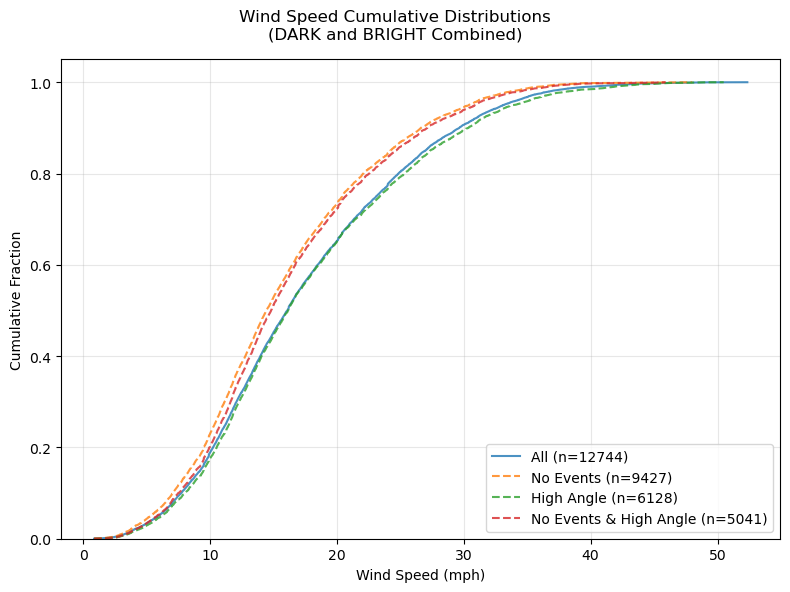

In [24]:
def compare_wind_distributions_no_backup(df):
    """
    Compare wind speed cumulative distributions between different data subsets,
    combining DARK and BRIGHT programs and excluding BACKUP.
    
    Parameters:
    -----------
    df : pandas.DataFrame
        DataFrame containing columns: 
        WIND_SPEED_AVG, WIND_OPENING_ANGLE, WIND_GUST_SUM, WIND_SHAKE_SUM, PROGRAM
    """
    # Create single plot
    fig, ax = plt.subplots(figsize=(8, 6))
    fig.suptitle('Wind Speed Cumulative Distributions\n(DARK and BRIGHT Combined)')
    
    # Get data excluding BACKUP
    program_mask = df['PROGRAM'].isin(['DARK', 'BRIGHT'])
    program_data = df[program_mask]
    
    # Define different subsets
    no_events = (program_data['WIND_GUST_SUM'] + program_data['WIND_SHAKE_SUM']) == 0
    high_angle = program_data['WIND_OPENING_ANGLE'] > 90
    no_events_high_angle = no_events & high_angle
    
    # Get wind speeds for each subset
    subsets = {
        'All': program_data['WIND_SPEED_AVG'].dropna(),
        'No Events': program_data[no_events]['WIND_SPEED_AVG'].dropna(),
        'High Angle': program_data[high_angle]['WIND_SPEED_AVG'].dropna(),
        'No Events & High Angle': program_data[no_events_high_angle]['WIND_SPEED_AVG'].dropna()
    }
    
    # Plot cumulative distributions
    for name, data in subsets.items():
        if len(data) > 0:
            # Sort data and calculate cumulative distribution
            sorted_data = np.sort(data)
            cumulative = np.arange(1, len(sorted_data) + 1) / len(sorted_data)
            
            # Plot with appropriate style and label
            style = '-' if name == 'All' else '--'
            ax.plot(sorted_data, cumulative, 
                   style,
                   label=f'{name} (n={len(data)})',
                   alpha=0.8)
    
    # Add KS test results comparing All vs No Events & High Angle
    #if len(subsets['All']) > 0 and len(subsets['No Events & High Angle']) > 0:
    #    ks_stat, p_value = stats.ks_2samp(subsets['All'], 
    #                                    subsets['No Events & High Angle'])
    #    ax.text(0.05, 0.05, f'KS test p-value:\n{p_value:.2e}', 
    #           transform=ax.transAxes, 
    #           bbox=dict(facecolor='white', alpha=0.8))
    
    # Customize plot
    ax.set_xlabel('Wind Speed (mph)')
    ax.set_ylabel('Cumulative Fraction')
    ax.legend(loc='lower right')
    ax.grid(True, alpha=0.3)
    ax.set_ylim(0, 1.05)
    
    plt.tight_layout()
    return fig, ax

def print_distribution_stats_no_backup(df):
    """
    Print statistical summary of wind speed distributions,
    combining DARK and BRIGHT programs and excluding BACKUP.
    """
    print("Wind Speed Distribution Statistics (DARK and BRIGHT Combined)")
    print("=========================================================")
    
    # Get data excluding BACKUP
    program_mask = df['PROGRAM'].isin(['DARK', 'BRIGHT'])
    program_data = df[program_mask]
    
    # Define subsets
    no_events = (program_data['WIND_GUST_SUM'] + program_data['WIND_SHAKE_SUM']) == 0
    high_angle = program_data['WIND_OPENING_ANGLE'] > 90
    no_events_high_angle = no_events & high_angle
    
    # Calculate statistics for each subset
    subsets = {
        'All Data': program_data['WIND_SPEED_AVG'].dropna(),
        'No Events': program_data[no_events]['WIND_SPEED_AVG'].dropna(),
        'High Angle': program_data[high_angle]['WIND_SPEED_AVG'].dropna(),
        'No Events & High Angle': program_data[no_events_high_angle]['WIND_SPEED_AVG'].dropna()
    }
    
    for name, data in subsets.items():
        if len(data) > 0:
            percentiles = np.percentile(data, [25, 50, 75, 95])
            print(f"\n{name}:")
            print(f"  Count: {len(data)}")
            print(f"  Mean ± Std: {data.mean():.1f} ± {data.std():.1f}")
            print(f"  Percentiles (25, 50, 75, 95): "
                  f"{percentiles[0]:.1f}, {percentiles[1]:.1f}, "
                  f"{percentiles[2]:.1f}, {percentiles[3]:.1f}")
    plt.savefig('wind_distributions.jpg')

# Example usage:

# Create cumulative distribution plot
fig, ax = compare_wind_distributions_no_backup(new_exposure_table)

# Print statistical summary
print_distribution_stats_no_backup(new_exposure_table)



Analysis for Opening Angles < 60°
Fraction of small angles in wind events: 0.500
Fraction of small angles in no-wind events: 0.247
Ratio (wind/no-wind): 2.026

Correlations for small angle cases:
Wind Speed vs Success:
  Correlation coefficient: -0.334
  P-value: 1.171e-124
Wind Direction vs Success:
  Correlation coefficient: 0.159
  P-value: 1.576e-28
Mount Azimuth vs Success:
  Correlation coefficient: 0.019
  P-value: 1.972e-01


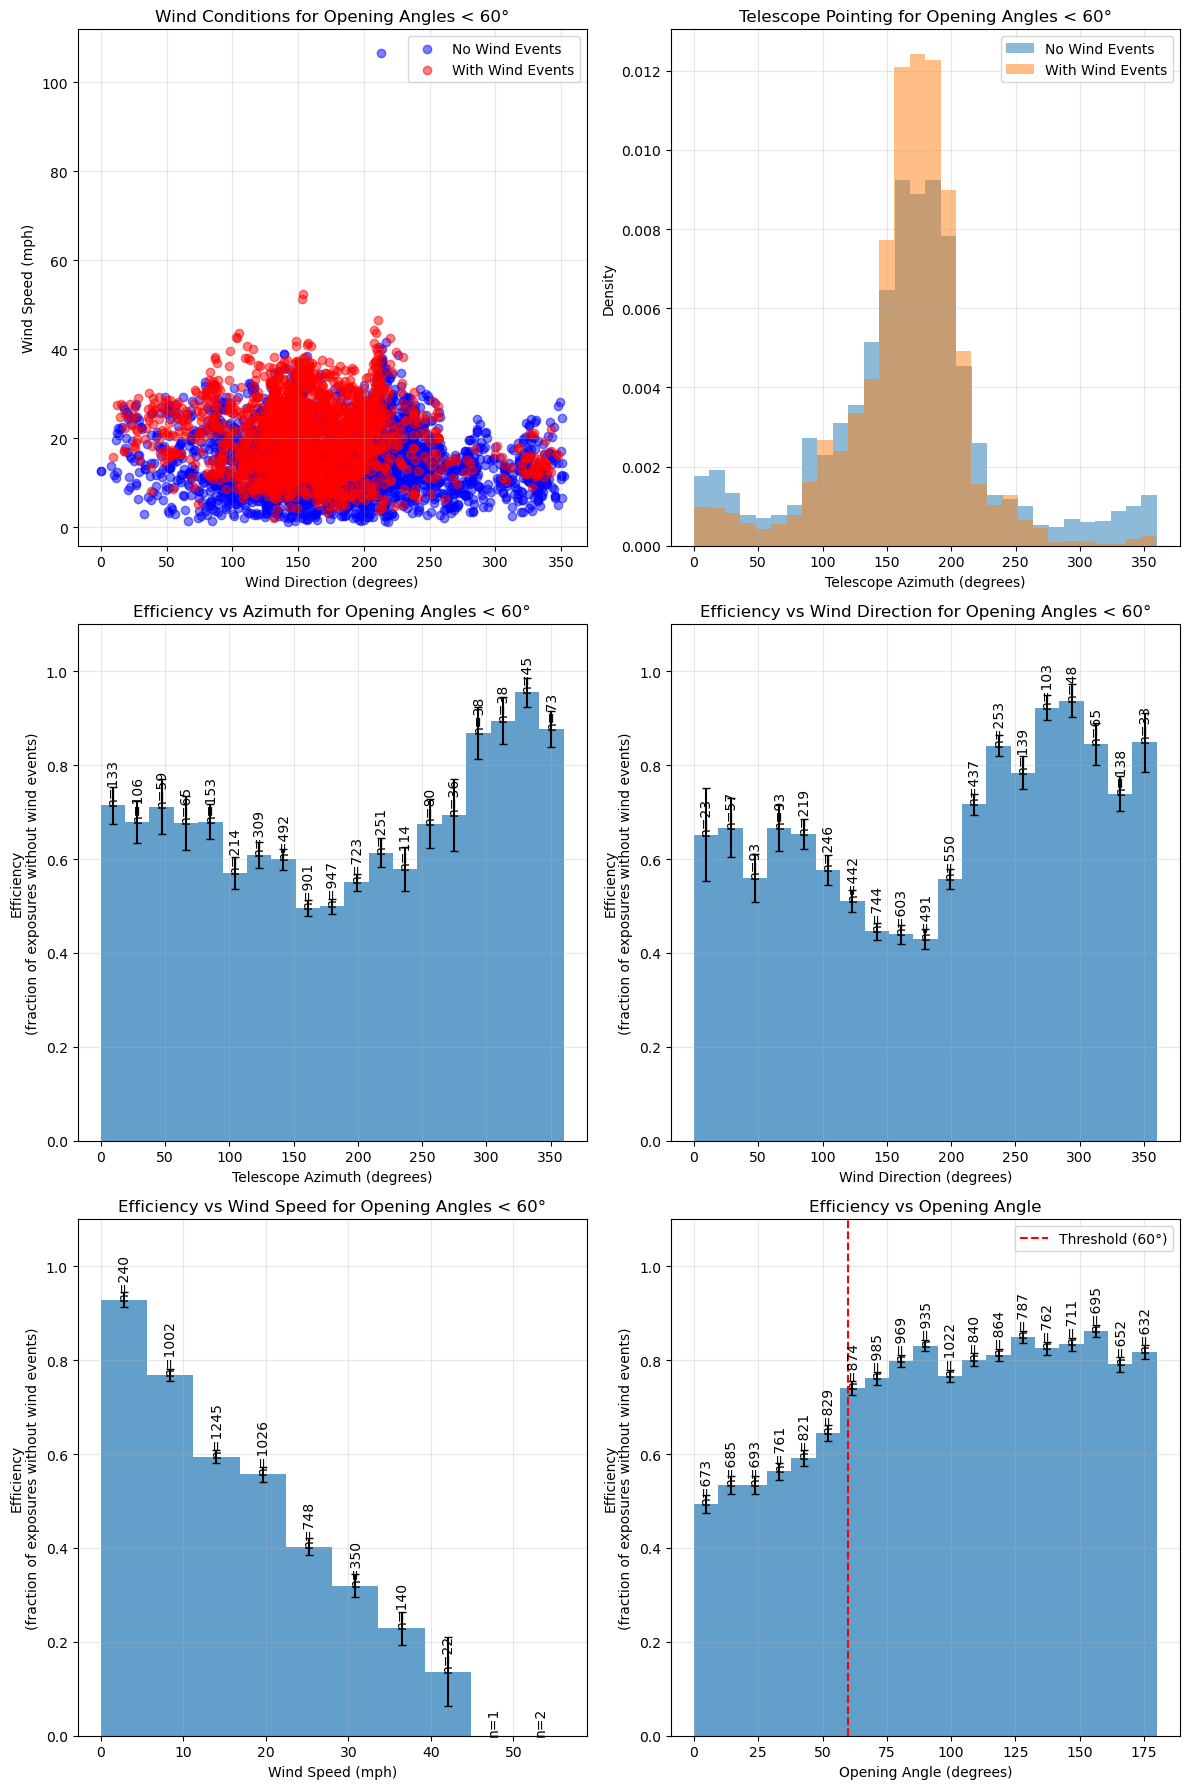

In [25]:
def analyze_wind_angle_conditions(df, angle_threshold=60):
    """
    Analyze the relationship between wind conditions and opening angles,
    including correlations with wind direction and pointing azimuth.
    
    Parameters:
    -----------
    df : pandas.DataFrame
        DataFrame containing columns: 
        WIND_OPENING_ANGLE, WIND_GUST_SUM, WIND_SHAKE_SUM, 
        WIND_DIRECTION_AVG, MOUNT_AZ, WIND_SPEED_AVG
    angle_threshold : int
        Threshold for opening angle analysis (default: 60 degrees)
    """
    # Create masks for different conditions
    wind_events = (df['WIND_GUST_SUM'] + df['WIND_SHAKE_SUM']) > 0
    no_wind_events = (df['WIND_GUST_SUM'] + df['WIND_SHAKE_SUM']) == 0
    small_angle = df['WIND_OPENING_ANGLE'] < angle_threshold
    
    # Calculate fractions for small opening angles
    def get_fraction(mask):
        subset = df[mask]
        if len(subset) == 0:
            return 0
        return np.mean(subset['WIND_OPENING_ANGLE'] < angle_threshold)
    
    fraction_with_wind = get_fraction(wind_events)
    fraction_no_wind = get_fraction(no_wind_events)
    
    ratio = fraction_with_wind / fraction_no_wind if fraction_no_wind > 0 else np.nan
    
    # Analyze conditions for successful small-angle observations
    success_mask = small_angle & no_wind_events
    problem_mask = small_angle & wind_events
    
    # Create figure with multiple subplots
    fig, axes = plt.subplots(3, 2, figsize=(12, 18))
    
    # 1. Wind Speed vs Direction for small angle cases
    scatter0 = axes[0,0].scatter(df[success_mask]['WIND_DIRECTION_AVG'],
                                df[success_mask]['WIND_SPEED_AVG'],
                                alpha=0.5, label='No Wind Events', c='blue')
    scatter1 = axes[0,0].scatter(df[problem_mask]['WIND_DIRECTION_AVG'],
                                df[problem_mask]['WIND_SPEED_AVG'],
                                alpha=0.5, label='With Wind Events', c='red')
    axes[0,0].set_xlabel('Wind Direction (degrees)')
    axes[0,0].set_ylabel('Wind Speed (mph)')
    axes[0,0].set_title(f'Wind Conditions for Opening Angles < {angle_threshold}°')
    axes[0,0].grid(True, alpha=0.3)
    axes[0,0].legend()
    
    # 2. Telescope Azimuth distribution
    axes[0,1].hist(df[success_mask]['MOUNT_AZ'], bins=30, alpha=0.5, 
                   label='No Wind Events', density=True)
    axes[0,1].hist(df[problem_mask]['MOUNT_AZ'], bins=30, alpha=0.5,
                   label='With Wind Events', density=True)
    axes[0,1].set_xlabel('Telescope Azimuth (degrees)')
    axes[0,1].set_ylabel('Density')
    axes[0,1].set_title(f'Telescope Pointing for Opening Angles < {angle_threshold}°')
    axes[0,1].grid(True, alpha=0.3)
    axes[0,1].legend()
    
# 3. Efficiency as a function of pointing azimuth
    az_bins = np.linspace(0, 360, 20)
    total_counts = []
    success_counts = []
    bin_centers = []
    
    for i in range(len(az_bins)-1):
        mask = (df['MOUNT_AZ'] >= az_bins[i]) & \
               (df['MOUNT_AZ'] < az_bins[i+1]) & \
               small_angle
        
        total = np.sum(mask)
        if total > 0:
            successes = np.sum(mask & no_wind_events)
            total_counts.append(total)
            success_counts.append(successes)
            bin_centers.append((az_bins[i] + az_bins[i+1])/2)
    
    efficiency = np.array(success_counts) / np.array(total_counts)
    
    # Create bar plot
    width = az_bins[1] - az_bins[0]
    axes[1,0].bar(bin_centers, efficiency, width=width, alpha=0.7)
    axes[1,0].errorbar(bin_centers, efficiency, 
                      yerr=np.sqrt(efficiency * (1-efficiency) / np.array(total_counts)),
                      fmt='none', color='black', capsize=3)
    
    # Add total counts as text above each bar
    for x, y, n in zip(bin_centers, efficiency, total_counts):
        axes[1,0].text(x, y, f'n={n}', 
                      horizontalalignment='center',
                      verticalalignment='bottom',
                      rotation=90)
    
    axes[1,0].set_xlabel('Telescope Azimuth (degrees)')
    axes[1,0].set_ylabel('Efficiency\n(fraction of exposures without wind events)')
    axes[1,0].set_title(f'Efficiency vs Azimuth for Opening Angles < {angle_threshold}°')
    axes[1,0].grid(True, alpha=0.3)
    axes[1,0].set_ylim(0, 1.1)  # Set y-axis from 0 to 1
    
# 4. Efficiency as a function of wind direction
    wind_dir_bins = np.linspace(0, 360, 20)
    total_counts = []
    success_counts = []
    bin_centers = []
    
    for i in range(len(wind_dir_bins)-1):
        mask = (df['WIND_DIRECTION_AVG'] >= wind_dir_bins[i]) & \
               (df['WIND_DIRECTION_AVG'] < wind_dir_bins[i+1]) & \
               small_angle
        
        total = np.sum(mask)
        if total > 0:
            successes = np.sum(mask & no_wind_events)
            total_counts.append(total)
            success_counts.append(successes)
            bin_centers.append((wind_dir_bins[i] + wind_dir_bins[i+1])/2)
    
    efficiency = np.array(success_counts) / np.array(total_counts)
    
    # Create bar plot
    width = wind_dir_bins[1] - wind_dir_bins[0]
    axes[1,1].bar(bin_centers, efficiency, width=width, alpha=0.7)
    axes[1,1].errorbar(bin_centers, efficiency, 
                      yerr=np.sqrt(efficiency * (1-efficiency) / np.array(total_counts)),
                      fmt='none', color='black', capsize=3)
    
    # Add total counts as text above each bar
    for x, y, n in zip(bin_centers, efficiency, total_counts):
        axes[1,1].text(x, y, f'n={n}', 
                      horizontalalignment='center',
                      verticalalignment='bottom',
                      rotation=90)
    
    axes[1,1].set_xlabel('Wind Direction (degrees)')
    axes[1,1].set_ylabel('Efficiency\n(fraction of exposures without wind events)')
    axes[1,1].set_title(f'Efficiency vs Wind Direction for Opening Angles < {angle_threshold}°')
    axes[1,1].grid(True, alpha=0.3)
    axes[1,1].set_ylim(0, 1.1)  # Set y-axis from 0 to 1
    
    plt.tight_layout()
    
    # Print summary statistics
    print(f"\nAnalysis for Opening Angles < {angle_threshold}°")
    print("=" * 50)
    print(f"Fraction of small angles in wind events: {fraction_with_wind:.3f}")
    print(f"Fraction of small angles in no-wind events: {fraction_no_wind:.3f}")
    print(f"Ratio (wind/no-wind): {ratio:.3f}")
    
    # Calculate correlations for small angle cases
    small_angle_data = df[small_angle].copy()
    if len(small_angle_data) > 0:
        print("\nCorrelations for small angle cases:")
        print("=" * 50)
        correlations = {
            'Wind Speed vs Success': stats.pointbiserialr(
                small_angle_data['WIND_SPEED_AVG'],
                ~wind_events[small_angle]
            ),
            'Wind Direction vs Success': stats.pointbiserialr(
                small_angle_data['WIND_DIRECTION_AVG'],
                ~wind_events[small_angle]
            ),
            'Mount Azimuth vs Success': stats.pointbiserialr(
                small_angle_data['MOUNT_AZ'],
                ~wind_events[small_angle]
            )
        }
        
        for name, (coef, pval) in correlations.items():
            print(f"{name}:")
            print(f"  Correlation coefficient: {coef:.3f}")
            print(f"  P-value: {pval:.3e}")

    # 5. Efficiency as a function of wind speed
    wind_speed_bins = np.linspace(0, df['WIND_SPEED_AVG'].max(), 20)
    total_counts = []
    success_counts = []
    bin_centers = []
    
    for i in range(len(wind_speed_bins)-1):
        mask = (df['WIND_SPEED_AVG'] >= wind_speed_bins[i]) & \
               (df['WIND_SPEED_AVG'] < wind_speed_bins[i+1]) & \
               small_angle
        
        total = np.sum(mask)
        if total > 0:
            successes = np.sum(mask & no_wind_events)
            total_counts.append(total)
            success_counts.append(successes)
            bin_centers.append((wind_speed_bins[i] + wind_speed_bins[i+1])/2)
    
    efficiency = np.array(success_counts) / np.array(total_counts)
    
    # Create bar plot
    width = wind_speed_bins[1] - wind_speed_bins[0]
    axes[2,0].bar(bin_centers, efficiency, width=width, alpha=0.7)
    axes[2,0].errorbar(bin_centers, efficiency, 
                      yerr=np.sqrt(efficiency * (1-efficiency) / np.array(total_counts)),
                      fmt='none', color='black', capsize=3)
    
    # Add total counts as text above each bar
    for x, y, n in zip(bin_centers, efficiency, total_counts):
        axes[2,0].text(x, y, f'n={n}', 
                      horizontalalignment='center',
                      verticalalignment='bottom',
                      rotation=90)
    
    axes[2,0].set_xlabel('Wind Speed (mph)')
    axes[2,0].set_ylabel('Efficiency\n(fraction of exposures without wind events)')
    axes[2,0].set_title(f'Efficiency vs Wind Speed for Opening Angles < {angle_threshold}°')
    axes[2,0].grid(True, alpha=0.3)
    axes[2,0].set_ylim(0, 1.1)
    
    # 6. Efficiency as a function of opening angle
    angle_bins = np.linspace(0, 180, 20)  # Full range of possible angles
    total_counts = []
    success_counts = []
    bin_centers = []
    
    for i in range(len(angle_bins)-1):
        mask = (df['WIND_OPENING_ANGLE'] >= angle_bins[i]) & \
               (df['WIND_OPENING_ANGLE'] < angle_bins[i+1])
        
        total = np.sum(mask)
        if total > 0:
            successes = np.sum(mask & no_wind_events)
            total_counts.append(total)
            success_counts.append(successes)
            bin_centers.append((angle_bins[i] + angle_bins[i+1])/2)
    
    efficiency = np.array(success_counts) / np.array(total_counts)
    
    # Create bar plot
    width = angle_bins[1] - angle_bins[0]
    axes[2,1].bar(bin_centers, efficiency, width=width, alpha=0.7)
    axes[2,1].errorbar(bin_centers, efficiency, 
                      yerr=np.sqrt(efficiency * (1-efficiency) / np.array(total_counts)),
                      fmt='none', color='black', capsize=3)
    
    # Add total counts as text above each bar
    for x, y, n in zip(bin_centers, efficiency, total_counts):
        axes[2,1].text(x, y, f'n={n}', 
                      horizontalalignment='center',
                      verticalalignment='bottom',
                      rotation=90)
    
    axes[2,1].set_xlabel('Opening Angle (degrees)')
    axes[2,1].set_ylabel('Efficiency\n(fraction of exposures without wind events)')
    axes[2,1].set_title('Efficiency vs Opening Angle')
    axes[2,1].grid(True, alpha=0.3)
    axes[2,1].set_ylim(0, 1.1)
    axes[2,1].axvline(x=angle_threshold, color='r', linestyle='--', 
                      label=f'Threshold ({angle_threshold}°)')
    axes[2,1].legend()
    
    plt.tight_layout()
    plt.savefig('full_analysis_small_opening_angle.jpg')
    return fig, axes

# Example usage:

# Run the analysis
fig, axes = analyze_wind_angle_conditions(new_exposure_table, angle_threshold=60)


In [27]:
special_exposures.iloc[0]

NameError: name 'special_exposures' is not defined